In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
import pickle


from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import GridSearchCV

from sklearn import tree
from sklearn import metrics

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score 
from sklearn.metrics import precision_score 
from sklearn.metrics import recall_score 
from sklearn.metrics import f1_score 
from sklearn.metrics import cohen_kappa_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor

En este notebook prepararé un modelo predictivo con el minimo de columnas posibles, por lo que eliminare todas las columnas menos relevantes.

EDA

In [2]:
df_diamond = pd.read_csv("Data/train.csv")

In [3]:
df_diamond.duplicated().sum()

0

In [4]:
df_diamond = df_diamond.drop(["id","x","y","z"], axis=1)

In [5]:
df_diamond.isnull().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
dtype: int64

In [6]:
df_diamond.duplicated().sum()

444

In [7]:
df_diamond.drop_duplicates(inplace=True)

In [8]:
df_diamond.duplicated().sum()

0

In [9]:
df_diamond.sort_values("price",ascending=False)

,carat,cut,color,clarity,depth,table,price
39601,2.07,Ideal,G,SI2,62.5,55.0,9.842
10629,2.00,Very Good,H,SI1,62.8,57.0,9.842
29519,1.51,Ideal,G,IF,61.7,55.0,9.842
3520,2.00,Premium,I,VS1,60.8,59.0,9.841
7332,2.29,Premium,I,SI1,61.8,59.0,9.841
...,...,...,...,...,...,...,...
34953,0.22,Fair,E,VS2,65.1,61.0,5.820
38044,0.24,Very Good,J,VVS2,62.8,57.0,5.817
33431,0.24,Very Good,I,VVS1,62.3,57.0,5.817
1323,0.31,Good,J,SI2,63.3,58.0,5.814


In [10]:
df_diamond.dtypes

carat      float64
cut         object
color       object
clarity     object
depth      float64
table      float64
price      float64
dtype: object

In [11]:
df_diamond_numeric = df_diamond.select_dtypes(include=np.number)
df_diamond_numeric

,carat,depth,table,price
0,0.30,62.4,58.0,6.353
1,1.01,62.7,56.0,9.183
2,0.72,61.8,59.0,7.983
3,1.08,63.2,57.0,8.371
4,0.36,62.3,59.0,6.588
...,...,...,...,...
40450,0.42,62.1,59.0,6.551
40451,0.53,62.0,58.0,7.382
40452,0.80,62.8,58.0,7.768
40453,1.01,61.5,57.0,8.726


In [12]:
df_diamond_categoric = df_diamond.select_dtypes(include=object)
df_diamond_categoric

,cut,color,clarity
0,Premium,D,SI2
1,Ideal,E,VVS2
2,Ideal,F,VS2
3,Very Good,G,SI2
4,Premium,G,VS1
...,...,...,...
40450,Premium,D,SI2
40451,Premium,G,VS2
40452,Good,G,SI2
40453,Very Good,F,VS2


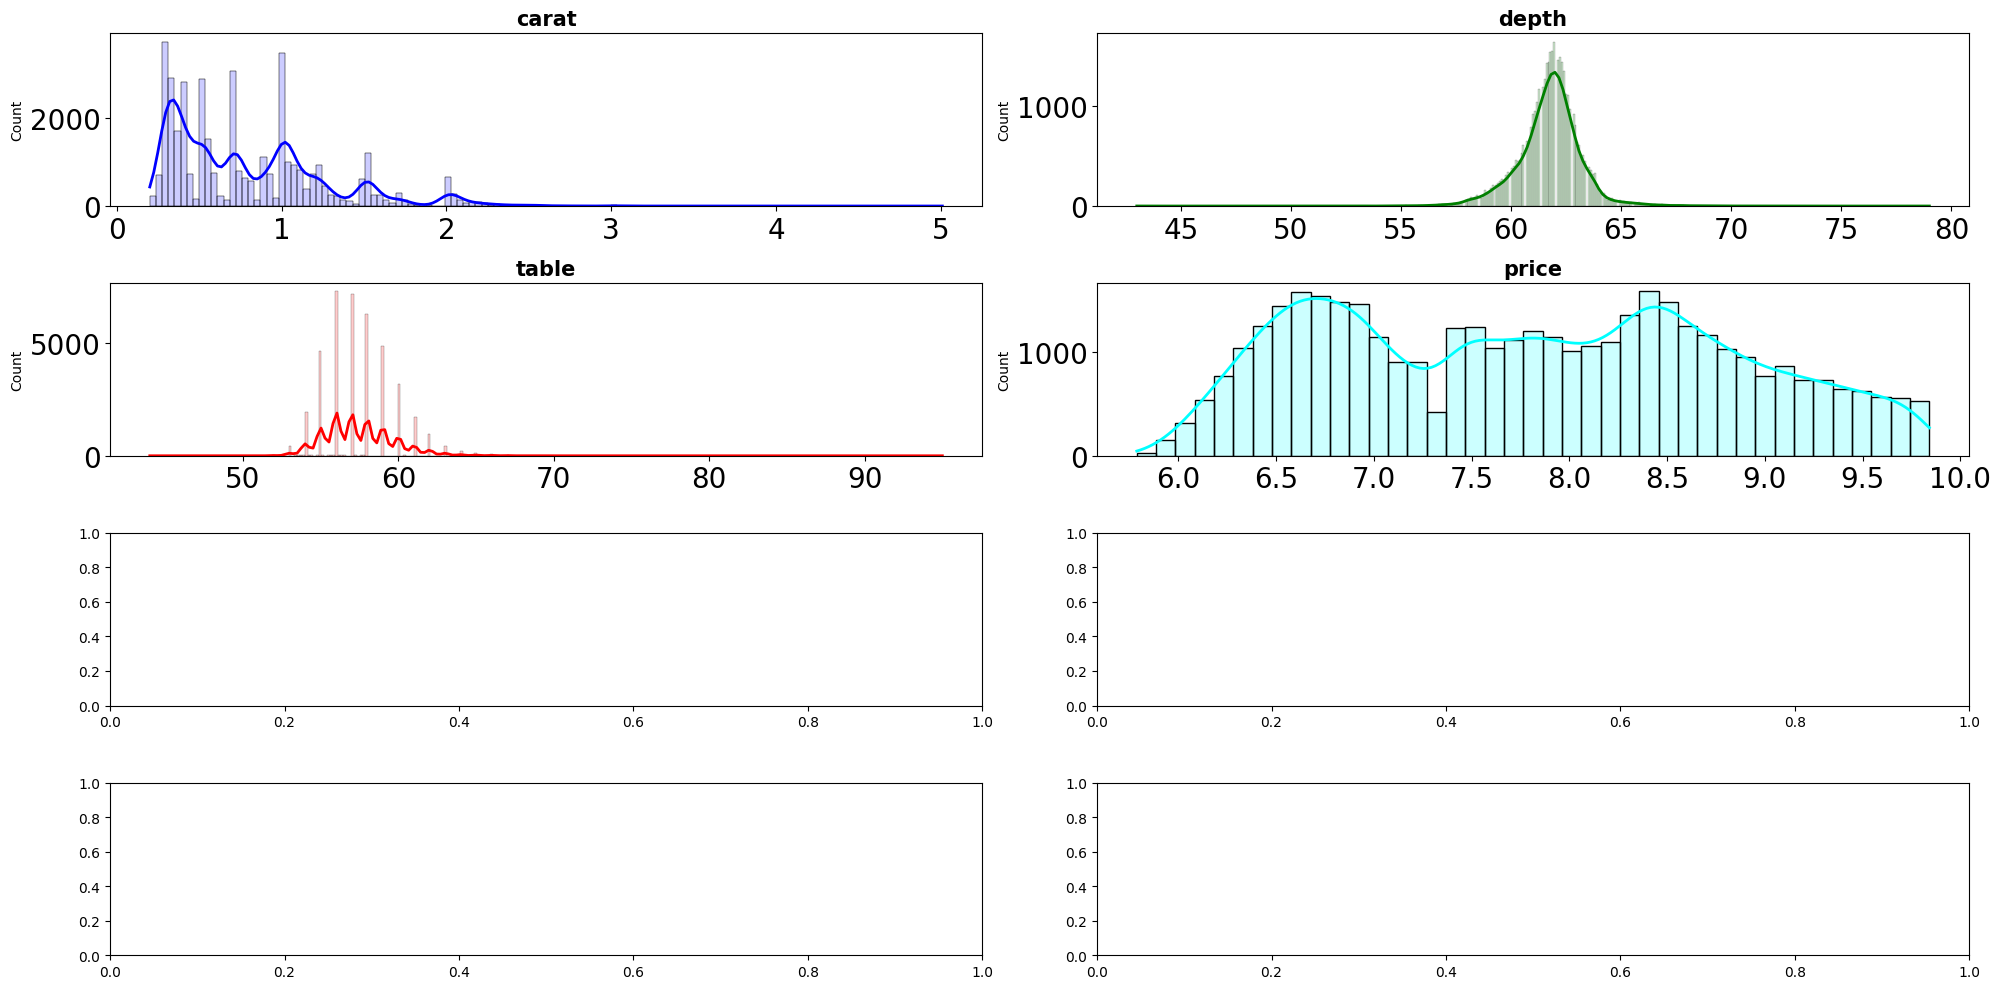

In [13]:
fig, axes = plt.subplots(nrows = 4, ncols = 2, figsize = (20, 10))

lista_colores = ["blue", "green", "red", "cyan", "magenta", "orange","orange","blue","yellow","purple"]

axes = axes.flat

columnas_numeric = df_diamond_numeric.select_dtypes(include = np.number).columns

for i, colum in enumerate(columnas_numeric): 
    sns.histplot(
        data = df_diamond_numeric,
        x = colum,
        kde = True, 
        color = lista_colores[i], 
        line_kws = {"linewidth": 2}, 
        alpha = 0.2, 
        ax = axes[i])
    
    
    axes[i].set_title(colum, fontsize = 15, fontweight = "bold")
    axes[i].tick_params(labelsize = 20)
    axes[i].set_xlabel("")
    

fig.tight_layout();

In [14]:
df_diamond_categoric

,cut,color,clarity
0,Premium,D,SI2
1,Ideal,E,VVS2
2,Ideal,F,VS2
3,Very Good,G,SI2
4,Premium,G,VS1
...,...,...,...
40450,Premium,D,SI2
40451,Premium,G,VS2
40452,Good,G,SI2
40453,Very Good,F,VS2


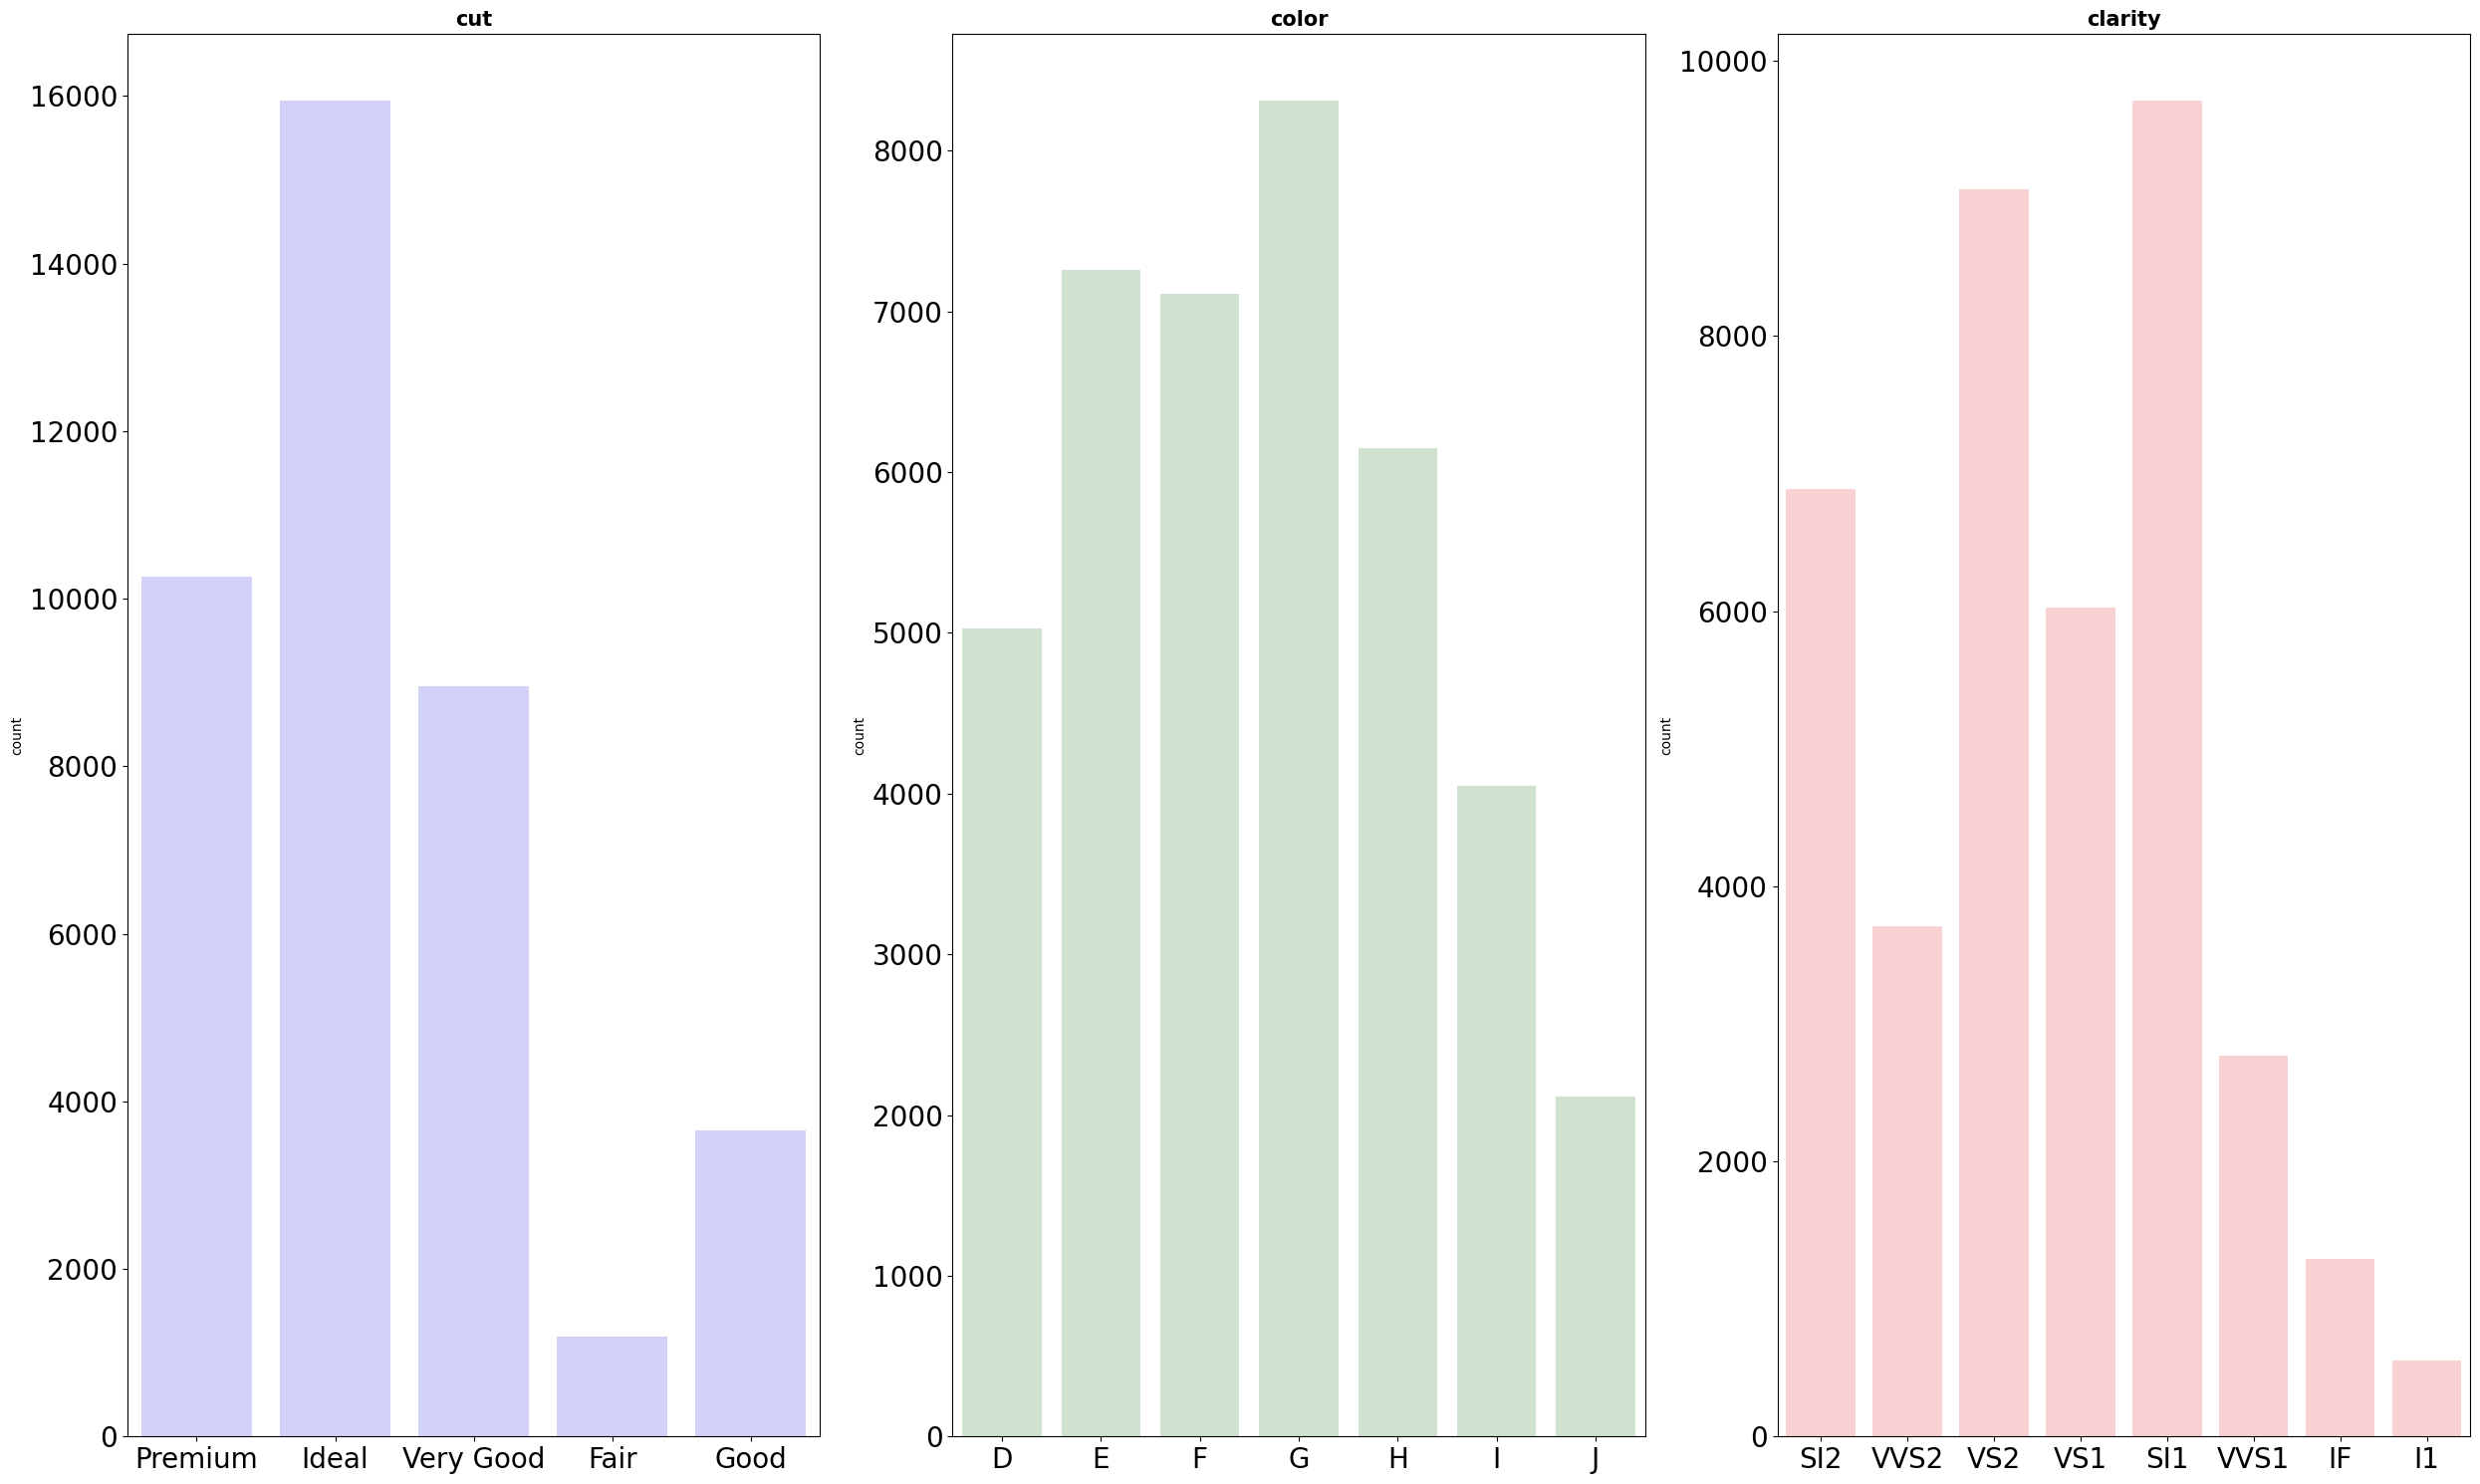

In [15]:
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (25, 15))

lista_colores = ["blue", "green", "red", "magenta", "orange", "yellow", "purple", "gold", "cyan","pink","silver","gray"]

axes = axes.flat

for i, colum in enumerate(df_diamond_categoric): 
    sns.countplot(
        data = df_diamond_categoric,
        x = colum,
        color = lista_colores[i], 
        alpha = 0.2, 
        ax = axes[i])
    
    
    axes[i].set_title(colum, fontsize = 15, fontweight = "bold")
    axes[i].tick_params(labelsize = 20)
    axes[i].set_xlabel("")
    

fig.tight_layout();

In [16]:

df_diamond_categoric

,cut,color,clarity
0,Premium,D,SI2
1,Ideal,E,VVS2
2,Ideal,F,VS2
3,Very Good,G,SI2
4,Premium,G,VS1
...,...,...,...
40450,Premium,D,SI2
40451,Premium,G,VS2
40452,Good,G,SI2
40453,Very Good,F,VS2


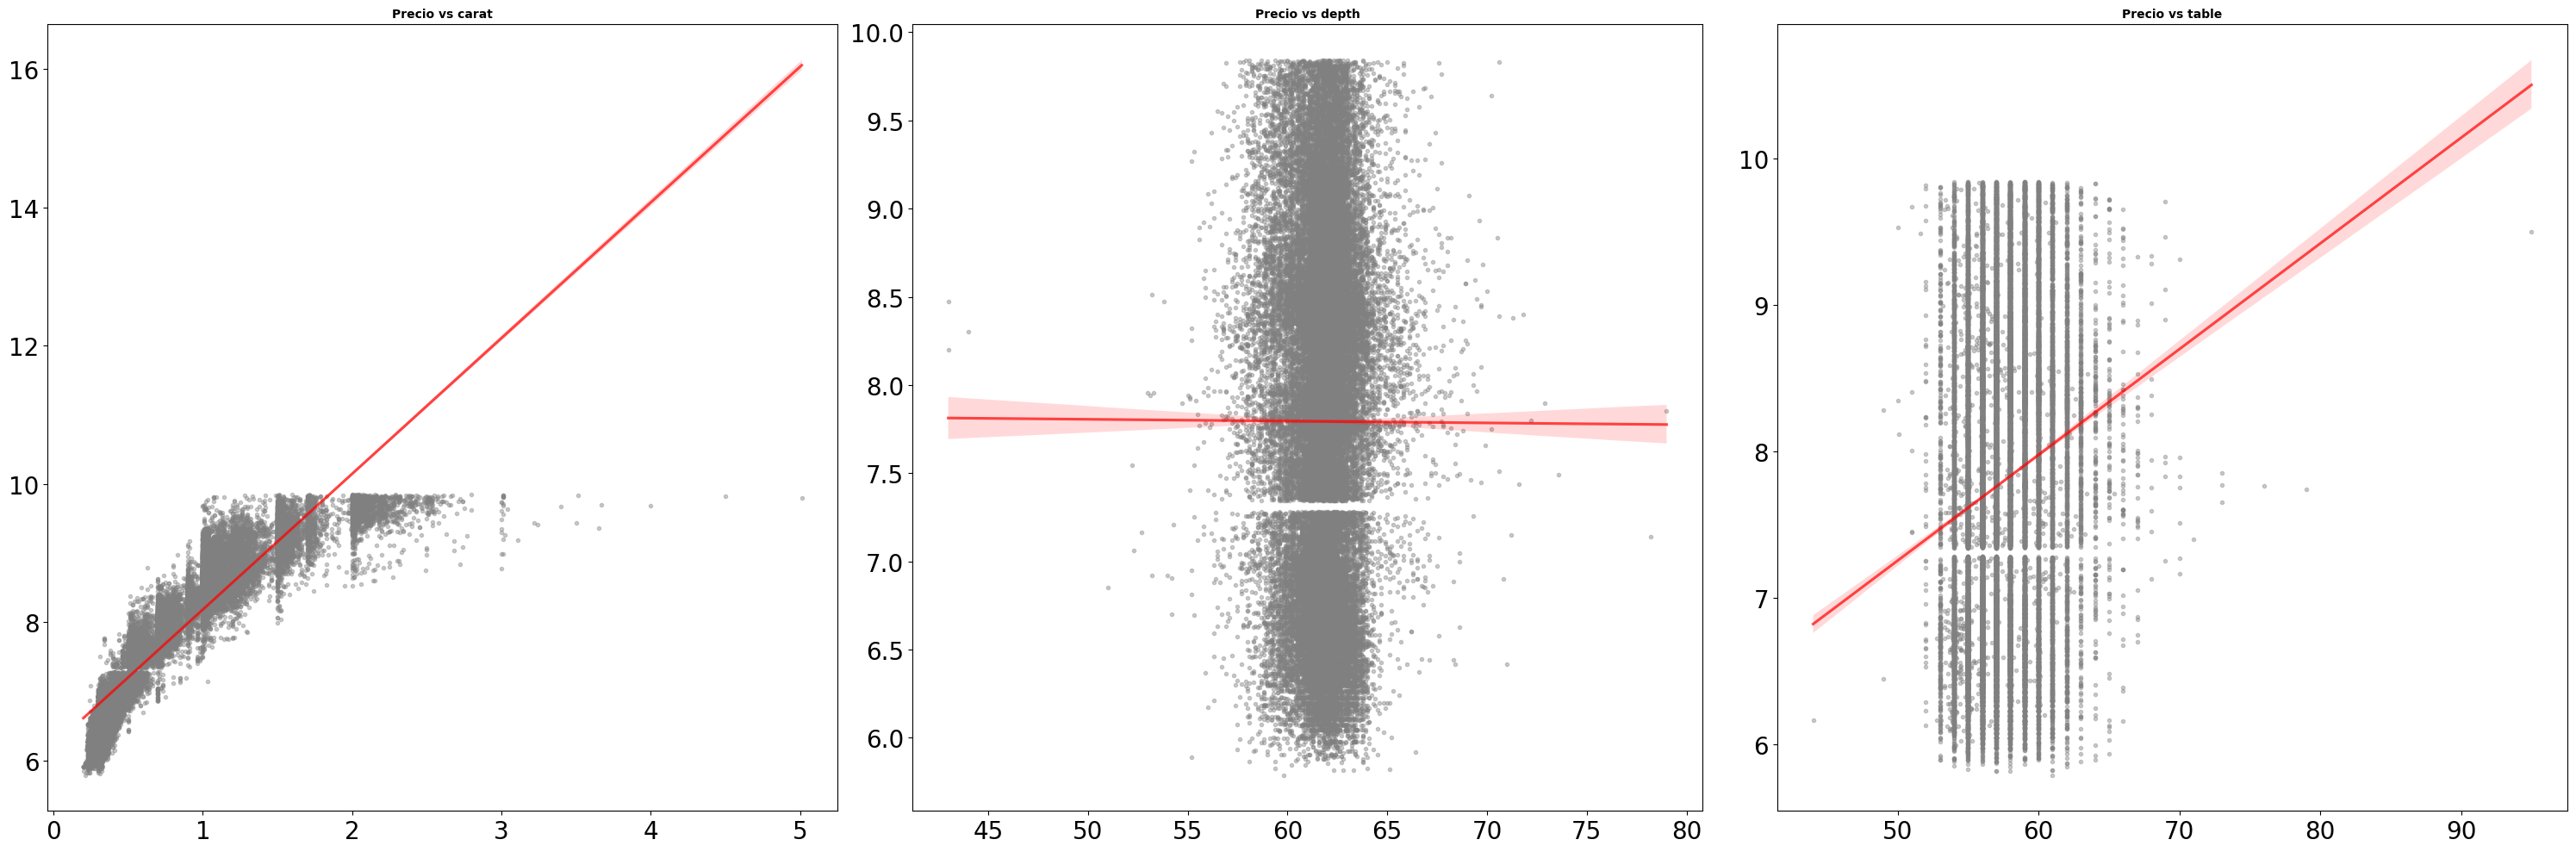

In [17]:
# Gráfico de relación entre variables predictoras y la variable a predecir
# ==============================================================================


fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (30, 10))

lista_colores = ["blue", "green", "red", "cyan", "magenta", "orange"]

axes = axes.flat

columnas_numeric = df_diamond.select_dtypes(include = np.number).columns
columnas_numeric = columnas_numeric.drop("price")

for i, colum in enumerate(columnas_numeric):
    sns.regplot(
        x = df_diamond[colum], 
        y = df_diamond["price"], 
        color = "gray", 
        marker = ".", 
        scatter_kws = {"alpha": 0.4}, 
        line_kws = {"color": "red", "alpha": 0.7 }, 
        ax = axes[i])
    
    axes[i].set_title(f"Precio vs {colum}", fontsize = 10, fontweight = "bold")
    axes[i].tick_params(labelsize = 20)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")
    
fig.tight_layout();

In [18]:
df_diamond

,carat,cut,color,clarity,depth,table,price
0,0.30,Premium,D,SI2,62.4,58.0,6.353
1,1.01,Ideal,E,VVS2,62.7,56.0,9.183
2,0.72,Ideal,F,VS2,61.8,59.0,7.983
3,1.08,Very Good,G,SI2,63.2,57.0,8.371
4,0.36,Premium,G,VS1,62.3,59.0,6.588
...,...,...,...,...,...,...,...
40450,0.42,Premium,D,SI2,62.1,59.0,6.551
40451,0.53,Premium,G,VS2,62.0,58.0,7.382
40452,0.80,Good,G,SI2,62.8,58.0,7.768
40453,1.01,Very Good,F,VS2,61.5,57.0,8.726


C:\Users\Sindri\AppData\Local\Temp\ipykernel_67724\641221808.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  mask = np.triu(np.ones_like(df_diamond.corr()))
C:\Users\Sindri\AppData\Local\Temp\ipykernel_67724\641221808.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_diamond.corr(),


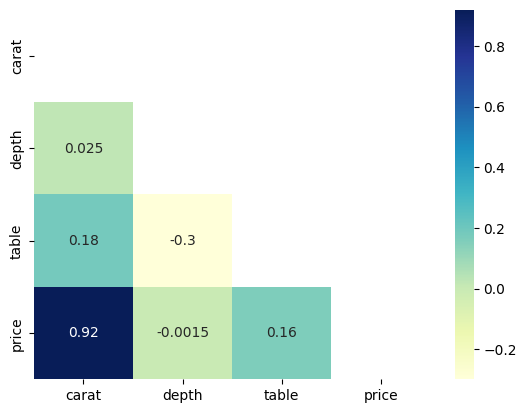

In [19]:
mask = np.triu(np.ones_like(df_diamond.corr()))
sns.heatmap(df_diamond.corr(), 
           cmap = "YlGnBu", 
            mask = mask,
           annot = True);

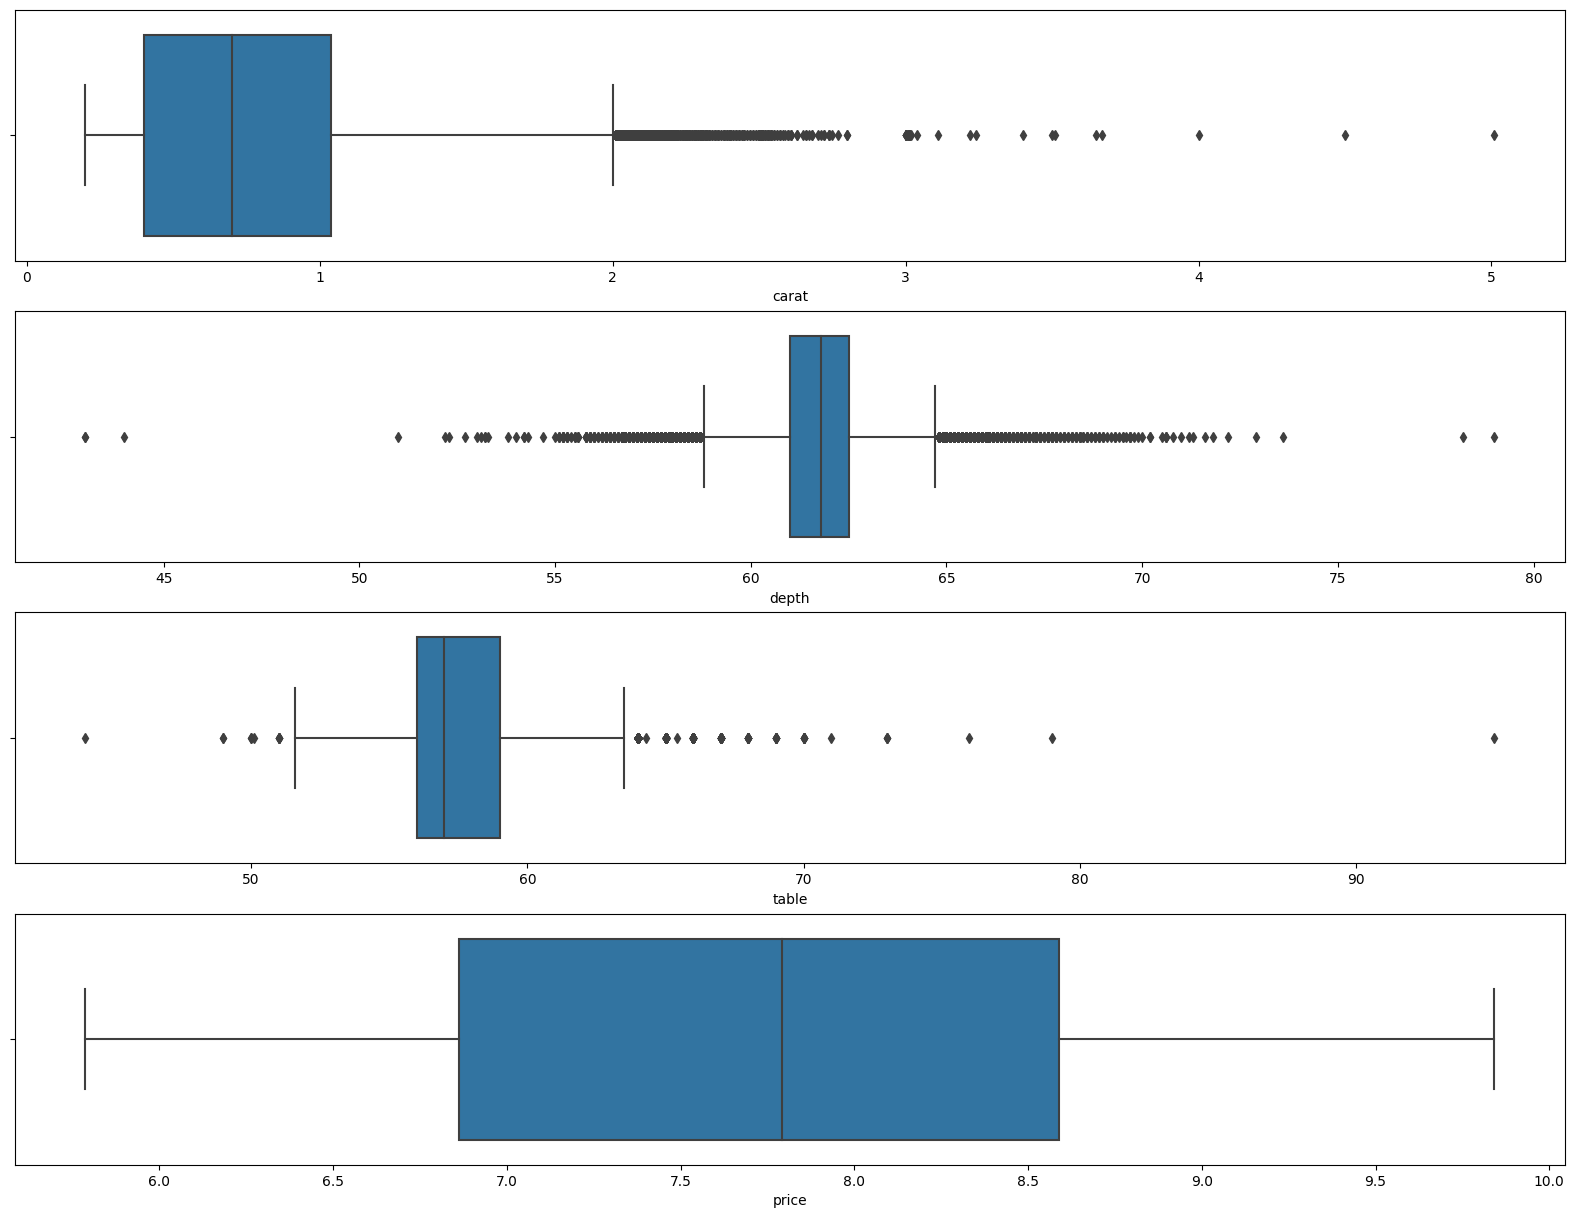

In [20]:
fig, ax = plt.subplots(4, 1, figsize=(20,15))

for i in range(len(df_diamond_numeric.columns)):
    sns.boxplot(x=df_diamond_numeric.columns[i], data=df_diamond_numeric, ax=ax[i])
plt.show()

In [21]:
df_diamond_categoric

,cut,color,clarity
0,Premium,D,SI2
1,Ideal,E,VVS2
2,Ideal,F,VS2
3,Very Good,G,SI2
4,Premium,G,VS1
...,...,...,...
40450,Premium,D,SI2
40451,Premium,G,VS2
40452,Good,G,SI2
40453,Very Good,F,VS2


In [22]:
df_diamond_categoric

,cut,color,clarity
0,Premium,D,SI2
1,Ideal,E,VVS2
2,Ideal,F,VS2
3,Very Good,G,SI2
4,Premium,G,VS1
...,...,...,...
40450,Premium,D,SI2
40451,Premium,G,VS2
40452,Good,G,SI2
40453,Very Good,F,VS2


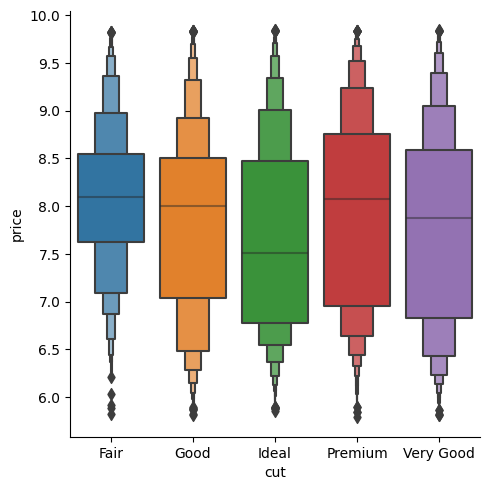

In [23]:
sns.catplot(
    data=df_diamond.sort_values("cut"),
    x="cut", y="price", kind="boxen",
);

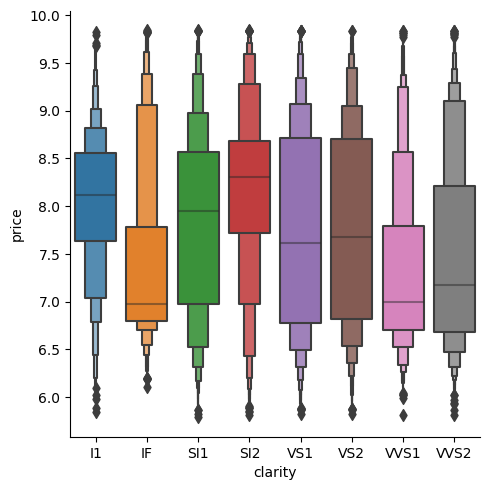

In [24]:
sns.catplot(
    data=df_diamond.sort_values("clarity"),
    x="clarity", y="price", kind="boxen",
);

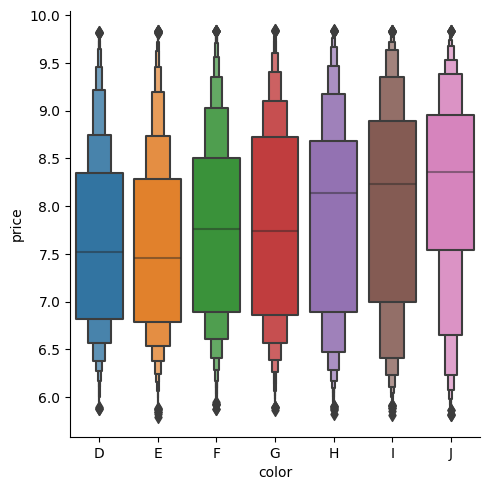

In [25]:
sns.catplot(
    data=df_diamond.sort_values("color"),
    x="color", y="price", kind="boxen",
);

In [26]:
df_diamond

,carat,cut,color,clarity,depth,table,price
0,0.30,Premium,D,SI2,62.4,58.0,6.353
1,1.01,Ideal,E,VVS2,62.7,56.0,9.183
2,0.72,Ideal,F,VS2,61.8,59.0,7.983
3,1.08,Very Good,G,SI2,63.2,57.0,8.371
4,0.36,Premium,G,VS1,62.3,59.0,6.588
...,...,...,...,...,...,...,...
40450,0.42,Premium,D,SI2,62.1,59.0,6.551
40451,0.53,Premium,G,VS2,62.0,58.0,7.382
40452,0.80,Good,G,SI2,62.8,58.0,7.768
40453,1.01,Very Good,F,VS2,61.5,57.0,8.726


In [27]:
df_diamond_train = df_diamond.drop(["depth","table"], axis = 1)


In [28]:
df_diamond_train

,carat,cut,color,clarity,price
0,0.30,Premium,D,SI2,6.353
1,1.01,Ideal,E,VVS2,9.183
2,0.72,Ideal,F,VS2,7.983
3,1.08,Very Good,G,SI2,8.371
4,0.36,Premium,G,VS1,6.588
...,...,...,...,...,...
40450,0.42,Premium,D,SI2,6.551
40451,0.53,Premium,G,VS2,7.382
40452,0.80,Good,G,SI2,7.768
40453,1.01,Very Good,F,VS2,8.726


In [29]:
df_diamond_numeric.drop(["depth","table"], axis=1, inplace=True)

Estandarización

In [30]:
df_test = df_diamond_numeric
df_test = df_test.drop("price",axis=1)

In [31]:
robust = RobustScaler()
robust2 = RobustScaler()

In [32]:
lista_num = df_test.columns

In [33]:
robust.fit(df_diamond_numeric[lista_num])



RobustScaler()

In [34]:
X_robust = robust.transform(df_diamond_numeric[lista_num])


In [55]:
df_diamond_numeric[lista_num] = X_robust
df_diamond_numeric

,carat,price
0,-0.625000,6.353
1,0.484375,9.183
2,0.031250,7.983
3,0.593750,8.371
4,-0.531250,6.588
...,...,...
40450,-0.437500,6.551
40451,-0.265625,7.382
40452,0.156250,7.768
40453,0.484375,8.726


In [36]:
with open('data/estandarizacion.pkl', 'wb') as s:
    pickle.dump(robust, s)

Encoding

In [37]:
df_diamond_categoric

,cut,color,clarity
0,Premium,D,SI2
1,Ideal,E,VVS2
2,Ideal,F,VS2
3,Very Good,G,SI2
4,Premium,G,VS1
...,...,...,...
40450,Premium,D,SI2
40451,Premium,G,VS2
40452,Good,G,SI2
40453,Very Good,F,VS2


In [38]:
df_diamond["clarity"].value_counts()

SI1     9709
VS2     9068
SI2     6887
VS1     6026
VVS2    3710
VVS1    2769
IF      1289
I1       553
Name: clarity, dtype: int64

In [39]:
cut_order = ['Premium', 'Very Good', 'Fair', 'Good', 'Ideal']
clarity_order = ['VS1','VS2','SI2','SI1','I1','VVS2','VVS1','IF']
color_order = ['J','I','G','H','F','D','E']

In [40]:
ordinal_cut = OrdinalEncoder(categories = [cut_order], dtype = int)
cut_transformed = ordinal_cut.fit_transform(df_diamond_categoric[["cut"]])
df_cut_transformed = pd.DataFrame(cut_transformed)
df_cut_transformed = df_cut_transformed.rename(columns={0:"cut"})
with open(f'data/encoding_cut.pkl', 'wb') as s:
    pickle.dump(ordinal_cut, s) 


In [41]:
ordinal_clarity = OrdinalEncoder(categories = [clarity_order], dtype = int)
clarity_transformed = ordinal_clarity.fit_transform(df_diamond_categoric[["clarity"]])
df_clarity_transformed = pd.DataFrame(clarity_transformed)
df_clarity_transformed = df_clarity_transformed.rename(columns={0:"clarity"})
with open(f'data/encoding_clarity.pkl', 'wb') as s:
    pickle.dump(ordinal_clarity, s) 

In [42]:
ordinal_color = OrdinalEncoder(categories = [color_order], dtype = int)
color_transformed = ordinal_color.fit_transform(df_diamond_categoric[["color"]])
df_color_transformed = pd.DataFrame(color_transformed)
df_color_transformed = df_color_transformed.rename(columns={0:"color"})
with open(f'data/encoding_color.pkl', 'wb') as s:
    pickle.dump(ordinal_color, s) 

In [43]:
df_diamond_categoric.drop(["cut","color","clarity"],axis=1,inplace=True)

In [53]:
df_diamond_categoric = pd.concat([df_cut_transformed,df_color_transformed,df_clarity_transformed],axis=1)
df_diamond_categoric = df_diamond_categoric.rename(columns={0:"cut",0:"color",0:"clarity"})
df_diamond_categoric

,cut,color,clarity
0,0,5,2
1,4,6,5
2,4,4,1
3,1,2,2
4,0,2,0
...,...,...,...
40006,0,5,2
40007,0,2,1
40008,3,2,2
40009,1,4,1


In [57]:
df_diamond_numeric= df_diamond_numeric.reset_index()

In [60]:
df_diamond_numeric = df_diamond_numeric.drop("index",axis=1)

In [61]:
df_diamond_numeric

,carat,price
0,-0.625000,6.353
1,0.484375,9.183
2,0.031250,7.983
3,0.593750,8.371
4,-0.531250,6.588
...,...,...
40006,-0.437500,6.551
40007,-0.265625,7.382
40008,0.156250,7.768
40009,0.484375,8.726


In [62]:
df_diamond_limpio = pd.concat([df_diamond_numeric,df_diamond_categoric],axis=1)
df_diamond_limpio

,carat,price,cut,color,clarity
0,-0.625000,6.353,0,5,2
1,0.484375,9.183,4,6,5
2,0.031250,7.983,4,4,1
3,0.593750,8.371,1,2,2
4,-0.531250,6.588,0,2,0
...,...,...,...,...,...
40006,-0.437500,6.551,0,5,2
40007,-0.265625,7.382,0,2,1
40008,0.156250,7.768,3,2,2
40009,0.484375,8.726,1,4,1


In [63]:
X = df_diamond_limpio.drop('price', axis =1)
y = df_diamond_limpio['price']


X_train, X_test, y_train, y_test = train_test_split(X, y, train_size   = 0.8, random_state = 42)

In [64]:
#Este modelo será para el test.
X2 = df_diamond_limpio.drop('price', axis =1)
y2 = df_diamond_limpio['price']

In [65]:
def metricas(y_test, y_train, y_test_pred, y_train_pred, tipo_modelo):
    
    
    resultados = {'MAE': [metrics.mean_absolute_error(y_test, y_test_pred), metrics.mean_absolute_error(y_train, y_train_pred)],
                'MSE': [metrics.mean_squared_error(y_test, y_test_pred), metrics.mean_squared_error(y_train, y_train_pred)],
                'RMSE': [np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)), np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))],
                'R2':  [metrics.r2_score(y_test, y_test_pred), metrics.r2_score(y_train, y_train_pred)],
                 "set": ["test", "train"]}
    df = pd.DataFrame(resultados)
    df["modelo"] = tipo_modelo
    return df

In [66]:
# create a regressor object
regressor = DecisionTreeRegressor(random_state = 0) 
  
# fit the regressor with X and Y data
regressor.fit(X_train, y_train)

DecisionTreeRegressor(random_state=0)

In [67]:
max_features = np.sqrt(len(X_train.columns))
max_features

2.0

In [68]:
print(regressor.tree_.max_depth)

26


In [69]:
y_pred_test_dt = regressor.predict(X_test)
y_pred_train_dt = regressor.predict(X_train)

In [70]:
dt_results1 = metricas(y_test, y_train, y_pred_test_dt, y_pred_train_dt, "Decission Tree I")
dt_results1

,MAE,MSE,RMSE,R2,set,modelo
0,0.087366,0.014099,0.118740,0.986171,test,Decission Tree I
1,0.053720,0.006097,0.078082,0.994105,train,Decission Tree I


In [72]:
param = {"max_depth": [12,13,14],
        "min_samples_split": [5,10,15,20,25],
        "max_features": [4,5,6]}

gs = GridSearchCV(
            estimator=DecisionTreeRegressor(),
            param_grid= param,
            cv=10,
            verbose=0,
            n_jobs = -1,
            return_train_score = True,
            scoring="neg_mean_squared_error")

In [73]:
%time
gs.fit(X_train, y_train)

CPU times: total: 0 ns
Wall time: 0 ns


GridSearchCV(cv=10, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'max_depth': [12, 13, 14], 'max_features': [4, 5, 6],
                         'min_samples_split': [5, 10, 15, 20, 25]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [74]:
best_tree = gs.best_estimator_
best_tree

DecisionTreeRegressor(max_depth=14, max_features=5, min_samples_split=20)

In [75]:
y_pred_test_dt2 = best_tree.predict(X_test)
y_pred_train_dt2 = best_tree.predict(X_train)

In [76]:
dt_results2 = metricas(y_test, y_train, y_pred_test_dt2, y_pred_train_dt2, "Decision tree II")

In [77]:
dt_results2

,MAE,MSE,RMSE,R2,set,modelo
0,0.082742,0.011931,0.109227,0.988298,test,Decision tree II
1,0.072511,0.009064,0.095205,0.991237,train,Decision tree II


In [78]:
df_all = pd.concat([dt_results1, dt_results2], axis = 0)
df_all

,MAE,MSE,RMSE,R2,set,modelo
0,0.087366,0.014099,0.118740,0.986171,test,Decission Tree I
1,0.053720,0.006097,0.078082,0.994105,train,Decission Tree I
0,0.082742,0.011931,0.109227,0.988298,test,Decision tree II
1,0.072511,0.009064,0.095205,0.991237,train,Decision tree II


In [80]:
param = {"max_depth": [12,13,14],
        "min_samples_split": [5,10,15,20,25],
        "max_features": [4,5,6]}

bosque = GridSearchCV(
            estimator=RandomForestRegressor(),
            param_grid= param,
            cv=10,
            verbose=0,
            n_jobs = -1,
            return_train_score = True,
            scoring="neg_mean_squared_error")

In [81]:
%time
bosque.fit(X_train, y_train)

CPU times: total: 0 ns
Wall time: 0 ns


GridSearchCV(cv=10, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [12, 13, 14], 'max_features': [4, 5, 6],
                         'min_samples_split': [5, 10, 15, 20, 25]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [82]:
bos = bosque.best_estimator_
bos

RandomForestRegressor(max_depth=13, max_features=5, min_samples_split=10)

In [83]:
y_pred_test_rf = bos.predict(X_test)
y_pred_train_rf = bos.predict(X_train)

In [84]:
rf_results = metricas(y_test, y_train, y_pred_test_rf, y_pred_train_rf, "Random Forest")
rf_results

,MAE,MSE,RMSE,R2,set,modelo
0,0.079701,0.010992,0.104841,0.989219,test,Random Forest
1,0.070338,0.008524,0.092327,0.991758,train,Random Forest


In [85]:
df_all = pd.concat([df_all, rf_results ], axis = 0)
df_all

,MAE,MSE,RMSE,R2,set,modelo
0,0.087366,0.014099,0.118740,0.986171,test,Decission Tree I
1,0.053720,0.006097,0.078082,0.994105,train,Decission Tree I
0,0.082742,0.011931,0.109227,0.988298,test,Decision tree II
1,0.072511,0.009064,0.095205,0.991237,train,Decision tree II
0,0.079701,0.010992,0.104841,0.989219,test,Random Forest
1,0.070338,0.008524,0.092327,0.991758,train,Random Forest


In [89]:
param = {"max_depth": [12,13,14],
        "min_samples_split": [5,10,15,20,25],
        "max_features": [3,4,5,6,7]}

# Búsqueda por grid search con validación cruzada
# ==============================================================================
grid = GridSearchCV(
        estimator  = GradientBoostingRegressor(),
        param_grid = param,
        n_jobs     = -1,
        verbose    = 1,
        cv         = 10, 
        return_train_score = True
       )

grid.fit(X = X_train, y = y_train)

Fitting 10 folds for each of 75 candidates, totalling 750 fits


In [87]:
y_pred_gb_test= grid.predict(X_test)
y_pred_gb_train= grid.predict(X_train)

In [88]:
results_gradient = metricas(y_test,  y_train, y_pred_gb_test, y_pred_gb_train, "Gradient")
results_gradient

,MAE,MSE,RMSE,R2,set,modelo
0,0.078254,0.010723,0.103554,0.989482,test,Gradient
1,0.066218,0.007629,0.087346,0.992624,train,Gradient


In [ ]:
df_all_results = pd.concat([df_all, results_gradient], axis = 0)
df_all_results

In [ ]:
fig, axes = plt.subplots(1,2, figsize =(15,5))

sns.barplot(data = df_all_results, x = "modelo", y = "R2", hue = "set", ax = axes[0], palette="mako")
sns.barplot(data = df_all_results, x = "modelo", y = "RMSE", hue = "set",ax = axes[1], palette = "mako");

Este es el modelo que usaré para el Test.

In [ ]:
param = {"max_depth": [10,11,12,13],
        "min_samples_split": [5,10,15,20,25],
        "max_features": [4,5,6]}

# Búsqueda por grid search con validación cruzada
# ==============================================================================
grid2 = GridSearchCV(
        estimator  = GradientBoostingRegressor(),
        param_grid = param,
        n_jobs     = -1,
        verbose    = 1,
        cv         = 10, 
        return_train_score = True
       )

grid2.fit(X = X2, y = y2)

In [ ]:
with open('data/mejor_modelo.pkl', 'wb') as modelo:
        pickle.dump(grid2, modelo)